# Partial Least Squares (PLS) Regression Models

## Libraries

In [53]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns
plt.style.use('seaborn-v0_8')

import scipy.stats as stats
from scipy.stats import pearsonr
from scipy.stats import linregress
import statsmodels.api as sm

from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

In [ ]:
# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Paths

In [4]:
DATA_ROOT = "./gaitrec_data"
# Train set
UNBALANCED_TRAIN_SET_METADATA_PATH = os.path.join(DATA_ROOT, "unbalanced_train_set_metadata.csv")
POSTPROCESSED_TRAIN_FOLDER = os.path.join(DATA_ROOT, 'postprocessed_train')
GROUPS_SESSIONS_DATA_TRAIN = os.path.join(DATA_ROOT, 'groups_sessions_data_train')
GRF_F_AP_PRO_DATA_TRAIN = os.path.join(DATA_ROOT, 'GRF_F_AP_PRO_data_train')
# Test set
TEST_SET_METADATA_PATH = os.path.join(DATA_ROOT, "test_set_metadata.csv")
TEST_FOLDER = os.path.join(DATA_ROOT, "test_set")
GROUPS_SESSIONS_DATA_TEST = os.path.join(DATA_ROOT, 'groups_sessions_data_test')
GRF_F_AP_PRO_DATA_TEST = os.path.join(DATA_ROOT, 'GRF_F_AP_PRO_data_test')

## Separar las features del target

- Separar las features (valores de la primera sesión) y el target (valores de la última sesión).
- Los valores de la primera sesión corresponden a las filas impares y los valores de la última sesión corresponden a las filas pares. 

In [5]:
def split_df_train_test(df_train: pd.DataFrame, df_test: pd.DataFrame):
    # Select only the columns of interest
    columns_of_interest = df_train.columns[3:]  # Exclude SUBJECT_ID, SESSION_ID, TRIAL_ID
    # Create X_train, y_train, X_test, y_test:
        # Extract the odd rows into X
        # Extract the even rows into y
    X_train = df_train.iloc[::2][columns_of_interest].values
    y_train = df_train.iloc[1::2][columns_of_interest].values
    X_test = df_test.iloc[::2][columns_of_interest].values
    y_test = df_test.iloc[1::2][columns_of_interest].values

    return X_train, y_train, X_test, y_test

## Load preprocessed data
- ANKLE data - 2 sessions

In [6]:
# train df
combined_legs_2sessions_A_train = pd.read_csv(os.path.join(GRF_F_AP_PRO_DATA_TRAIN, 
                              'groups_2sessions_data_train/A_data/combined.csv'))
# test df
combined_legs_2sessions_A_test = pd.read_csv(os.path.join(GRF_F_AP_PRO_DATA_TEST, 
                              'groups_2sessions_data_test/A_data/combined.csv'))

## Train - Test split

In [7]:
# train - test split 
X_train_A2, y_train_A2, X_test_A2, y_test_A2 = split_df_train_test(
                                                df_train = combined_legs_2sessions_A_train, 
                                                df_test = combined_legs_2sessions_A_test)

## Model 5: Partial Least Squares (PLS) Regression

### Training the PLS 

In [22]:
def train_and_evaluate_pls(X_train: np.ndarray, y_train: np.ndarray, best_n_comps: int) -> tuple:
    """
    Train and evaluate a PLS Regression model.

    Parameters:
        X_train (np.ndarray): Training data with shape (num_samples, num_features).
        y_train (np.ndarray): Training target data with shape (num_samples, num_targets).
        best_n_comps (float): Best number of components. 

    Returns:
        PLSRegression: Fitted PLS Regression model.
        float: Root mean square error (RMSE) score.
        float: R-squared score.
        float: Correlation coefficient (Pearson's r).
    """
    # Initialize a PLS Regression model
    pls = PLSRegression(scale=False) # scale=False because all the variables have been previously normalized (GaitRec dataset)

    # Hyperparameter tuning using GridSearchCV and 10-fold cross-validation
    n_comps = range(1, 21)
    param_grid = {'n_components': n_comps} # range of components (latent variables or factors) to be tested 
    # Create GridSearchCV object with k-fold cross-validation
    # scoring='neg_root_mean_squared_error': is specifying the scoring metric as the negative root mean squared error (RMSE). 
    # The negative sign is used because GridSearchCV aims to maximize the score, while we want to minimize the RMSE. 
    # By using the negative RMSE, scikit-learn will find the hyperparameters that result in the smallest (most negative) RMSE, 
    # effectively achieving the goal of minimizing RMSE.
    grid_search_rmse = GridSearchCV(pls, 
                                    param_grid, 
                                    scoring=make_scorer(mean_squared_error, 
                                                        squared=False, 
                                                        greater_is_better=False), # the same: scoring='neg_root_mean_squared_error'; or r2
                                        cv=10) 
  
    # Fit the GridSearchCV object on the training data
    grid_search_rmse.fit(X_train, y_train)

    # Best hyperparameters
    best_n_components_rmse = grid_search_rmse.best_params_['n_components']
    print(f"Best number of components for RMSE: {best_n_components_rmse}\n")
 
    # Plot RMSE vs Number of Components
    plt.figure(figsize=(6, 4))
    plt.plot(n_comps, grid_search_rmse.cv_results_['mean_test_score'], marker='o')
    plt.axvline(x=best_n_components_rmse, color='red', linestyle='--', label='Best n_components')
    plt.xlabel('Number of PLS components')
    plt.ylabel('RMSE')
    plt.title('RMSE vs Number of PLS Components')
    plt.xticks(n_comps)  # Set explicit x-axis ticks
    plt.legend()
    plt.show()
    """
    Note: The negative RMSE scores on the y-axis are likely due to the fact that we've used the greater_is_better=False 
    argument when defining the scoring metric for the GridSearchCV object. This argument tells scikit-learn that 
    lower values of the scoring metric are better. Since RMSE is a measure of the error and we want to minimize it, 
    setting greater_is_better to False is correct. 
    However, it causes the RMSE values to be reported as negative. This is a convention used by scikit-learn: 
    it multiplies the metric by -1 so that higher values are treated as better, which aligns with the default behavior of GridSearchCV.
    In the context of our code, the negative RMSE values indicate that the RMSE is being minimized. 
    So, we consider the negative sign as an artifact of the scikit-learn convention.
    """
    
    ##### R-squared #####
    grid_search_r2 = GridSearchCV(pls, 
                                param_grid, 
                                scoring="r2",
                                cv=10) 
    grid_search_r2.fit(X_train, y_train)
    best_n_components_r2 = grid_search_r2.best_params_['n_components']
    print(f"Best number of components for R-squared: {best_n_components_r2}\n")

    # Plot R2 vs Number of Components
    plt.figure(figsize=(6, 4))
    plt.plot(n_comps, grid_search_r2.cv_results_['mean_test_score'], marker='o')
    plt.axvline(x=best_n_components_r2, color='red', linestyle='--', label='Best n_components')
    plt.xlabel('Number of PLS components')
    plt.ylabel('R2')
    plt.title('R2 vs Number of PLS Components')
    plt.xticks(n_comps)  # Set explicit x-axis ticks
    plt.legend()
    plt.show()
    ###############

    # Train PLS Regression model with best hyperparameters: fit the model on the training data
    pls_model = PLSRegression(n_components=best_n_comps)
    pls_model.fit(X_train, y_train)

    # Perform cross-validation and get predicted values
    predicted_y = cross_val_predict(pls_model, X_train, y_train, cv=10)

    # Calculate RMSE
    rmse = mean_squared_error(y_train, predicted_y, squared=False)

    # Calculate R2 score
    r2 = r2_score(y_train, predicted_y)

    # Calculate correlation coefficient
    corr_coeff, _ = pearsonr(y_train.flatten(), predicted_y.flatten())

    # Print the results
    print("Results on Training Set:")
    print(f" RMSE: {rmse:.3f}")
    print(f" R2 Score: {r2:.3f}")
    print(f" Correlation coefficient: {corr_coeff:.3f}")

    return pls_model, rmse, r2, corr_coeff

Best number of components for RMSE: 11



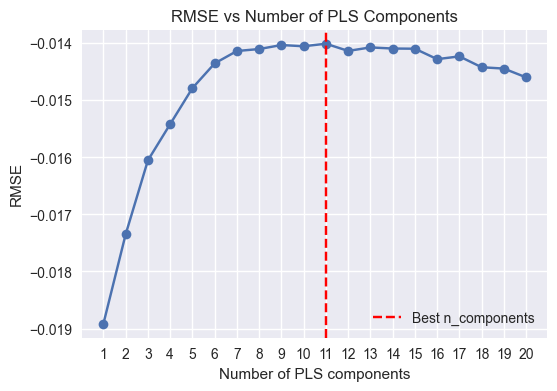

Best number of components for R-squared: 15



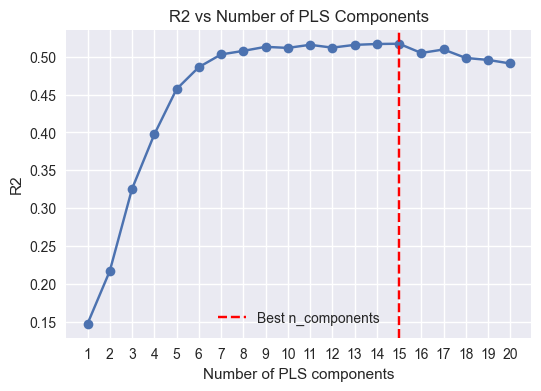

Results on Training Set:
 RMSE: 0.014
 R2 Score: 0.581
 Correlation coefficient: 0.986


In [56]:
# PLS model (training data): 11 components
pls_model, rmse, r2, corr_coeff = train_and_evaluate_pls(X_train = X_train_A2, 
                                                         y_train = y_train_A2,
                                                         best_n_comps = 11)

- Aunque nos indica que el mejor número de componentes es 11, si observamos el gráfico vemos que el RMSE no mejora significativamente a partir de 8. Por tanto, para no añadir complejidad al modelo, nos quedamos con 8 componentes. 
- En el momento en que el cambio no es superior al 2%, ya no nos quedamos con una nueva componente. Como menos componentes necesitemos para modelar nuestro fenómento, mejor. En nuestro caso, elegir 11 componentes respecto a 8 no aporta nada. 

Best number of components for RMSE: 11



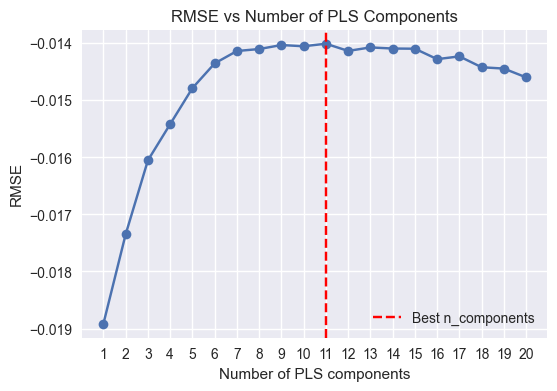

Best number of components for R-squared: 15



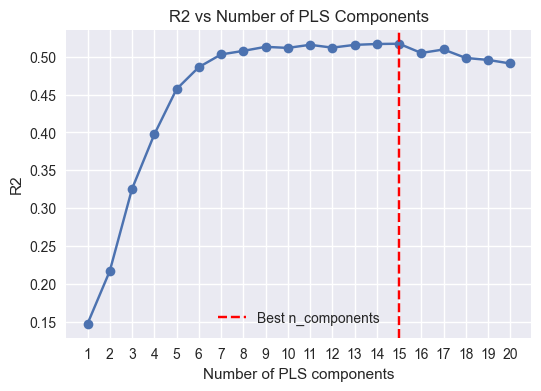

Results on Training Set:
 RMSE: 0.014
 R2 Score: 0.585
 Correlation coefficient: 0.986


In [24]:
# PLS model (training data): 8 components
pls_model, rmse, r2, corr_coeff = train_and_evaluate_pls(X_train = X_train_A2, 
                                                         y_train = y_train_A2,
                                                         best_n_comps = 8)

### Model evaluation

#### Evaluation pipeline

In [133]:
def evaluate_PLS_model_on_test_set(model, X_test, y_test):
    """
    Evaluate the fitted PLS model on the test set.

    Parameters:
        model (PLSRegression): Fitted PLS model.
        X_test (np.ndarray): Test data with shape (num_samples, num_features).
        y_test (np.ndarray): True test target data with shape (num_samples, num_targets).

    Returns:
        List[float]: List of root mean square error (RMSE) scores for each target variable.
        float: Overall root mean square error (RMSE) score averaged across all target variables.
        List[float]: List of correlation coefficients (Pearson's r) for each target variable.
        float: Overall correlation coefficient (Pearson's r) across all target variables.
        List[float]: List of coefficient of determination (R-squared) for each target variable.
        float: Overall coefficient of determination (R-squared) across all target variables.
        List[float]: List of adjusted R-squared for each target variable.
        float: Overall adjusted R-squared across all target variables.
        np.ndarray: Predicted target values for the test set with shape (num_samples, num_targets).
    """
    num_targets = y_test.shape[1]
    rmse_scores_test = []
    correlation_coeffs = []
    coeff_determination_r2 = []

    # Apply the dimension reduction learned on the train data.
    y_pred_test = model.predict(X_test)

    for i in range(num_targets):
        y_test_single = y_test[:, i]
        y_pred = y_pred_test[:, i]

        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(y_test_single, y_pred)) # this also works: rmse = np.sqrt(np.average((y_test_single - y_pred)**2, axis=0))
        rmse_scores_test.append(rmse)

        # Calculate correlation coefficient (Pearson's r)
        corr_coeff, _ = pearsonr(y_test_single, y_pred)
        correlation_coeffs.append(corr_coeff)

        # Calculate coefficient of determination (R-squared)
        r2 = r2_score(y_test_single, y_pred)
        coeff_determination_r2.append(r2)


    # Calculate overall RMSE
    # overall_rmse = np.sqrt(np.mean(np.array(rmse_scores_test) ** 2))
    overall_rmse = mean_squared_error(y_test, y_pred_test, squared=False)

    # Calculate overall correlation coefficient
    overall_corr_coeff, _ = pearsonr(y_test.flatten(), y_pred_test.flatten())

    # Calculate overall coefficient of determination (R-squared)
    overall_coeff_determination_r2 = r2_score(y_test, y_pred_test)

    return rmse_scores_test, overall_rmse, correlation_coeffs, overall_corr_coeff, coeff_determination_r2, overall_coeff_determination_r2, y_pred_test


def plot_predictions_vs_true(y_true: np.ndarray, 
                             y_pred: np.ndarray, 
                             rmse_scores_test: list[float],
                             corr_target_test: list[float]) -> None:
    """
    Plot scatter plots of predicted values against true values for each target variable.

    Parameters:
        y_true (np.ndarray): The true target values with shape (n_samples, n_targets).
        y_pred (np.ndarray): The predicted target values with shape (n_samples, n_targets).
        rmse_scores_test (list[float]): List of RMSE scores for each target variable on the test set.
        corr_target_test (list[float]): List of correlation coefficients for each target variable. 

    Returns:
        None
    """
    num_targets = y_true.shape[1]
    num_rows = int(np.ceil(num_targets / 4)) # 3
    fig, axes = plt.subplots(num_rows, 4, figsize=(28, 6 * num_rows)) # 3 15 5 
    # fig.subplots_adjust(hspace=0.8)  # Adjust spacing between rows
    axes = axes.flatten()

    for target in range(num_targets):
        axes[target].scatter(y_true[:, target], y_pred[:, target], alpha=0.6)
        
        # Calculate linear regression line
        slope, intercept, r_value, p_value, _ = linregress(y_true[:, target], y_pred[:, target])
        reg_line = slope * y_true[:, target] + intercept
        
        # Plot linear regression line
        axes[target].plot(y_true[:, target], reg_line, color='blue', label=f'Linear Reg. Line (y={slope:.2f}x + {intercept:.2f})')
        
        # Plot perfect correlation line
        axes[target].plot([y_true[:, target].min(), y_true[:, target].max()],
                          [y_true[:, target].min(), y_true[:, target].max()],
                          color='red', linestyle='dashed', label='Perfect Correlation Line')
        
        axes[target].set_xlabel('True Values', fontsize=22)
        axes[target].set_ylabel('Predicted Values', fontsize=22)
        axes[target].set_title(f"Target {target + 1}: Predicted vs True Values\nRMSE: {rmse_scores_test[target]:.3f}   Corr: {corr_target_test[target]:.3f}", fontsize=22)
        axes[target].legend(fontsize=18)

    # Hide empty subplots, if any
    for i in range(num_targets, len(axes)):
        axes[i].axis('off')

    plt.tight_layout(h_pad=3.0)  # Increase h_pad to add more vertical space between rows
    plt.show()


def plot_correlation_model(y_true: np.ndarray, 
                           y_pred: np.ndarray, 
                           overall_corr_coeff: float) -> None:
    """
    Create a global correlation plot of the model's predictions with all points and a reference line.

    Parameters:
        y_true (np.ndarray): The true target values with shape (n_samples, n_targets).
        y_pred (np.ndarray): The predicted target values with shape (n_samples, n_targets).
        overall_corr_coeff (float): Overall correlation coefficient (Pearson's r) across all target variables.

    Returns:
        None
    """
    
    # Flatten the true and predicted values
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    # Create a scatter plot of true values against predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true_flat, y_pred_flat, alpha=0.7)

    # Calculate the linear regression line parameters
    slope, intercept, r_value, p_value, std_err = linregress(y_true_flat, y_pred_flat)
    line = slope * y_true_flat + intercept

    # Plot the linear regression line
    plt.plot(y_true_flat, line, color='black', label='Linear Regression Line')

    # Plot the reference line for perfect correlation
    plt.plot(y_true_flat, y_true_flat, color='red', linestyle='-', label='Perfect Correlation Line')

    # Add labels and title
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('Correlation Plot of Model Predictions')

    # Annotate the overall correlation coefficient and linear equation on the plot
    equation = f'y = {slope:.3f}x + {intercept:.3f}'
    # plt.text(0.02, 0.83, f'Overall Correlation (Pearson r = {overall_corr_coeff:.3f})\n{equation}', 
    #          transform=plt.gca().transAxes, fontsize=11, verticalalignment='center', 
    #          bbox=dict(facecolor='white', alpha=0.8))
    plt.text(0.02, 0.85, f'Overall Correlation (Pearson r = {overall_corr_coeff:.3f})', 
             transform=plt.gca().transAxes, fontsize=11, verticalalignment='center', 
             bbox=dict(facecolor='white', alpha=0.8))
    plt.text(0.02, 0.78, equation, transform=plt.gca().transAxes, fontsize=11, verticalalignment='center', bbox=dict(facecolor='white', alpha=0.8))

    # Add legend with lines
    plt.legend(loc='best')

    plt.show()

def plot_last_session_mean_prediction_vs_mean_true(y_true: np.ndarray, 
                                                   y_pred: np.ndarray, 
                                                   overall_rmse: float,
                                                   overall_corr: float,
                                                   overall_r2: float,
                                                   time_points: int = 101,
                                                   x_ticks: int = 10) -> None:
    """
    Plot mean prediction values against mean true values for each target variable.

    Parameters:
        y_true (np.ndarray): The true target values with shape (n_samples, n_targets).
        y_pred (np.ndarray): The predicted target values with shape (n_samples, n_targets).
        overall_rmse (float): The overall root mean square error (RMSE) of the model.
        overall_corr (float): The overall correlation coefficient of the model.
        overall_r2 (float): The overall coefficient of determination (R-squared) of the model.
        time_points (int): Number of time points.
        x_ticks (int): Interval for x-axis ticks.

    Returns:
        None
    """
    # Create the x-axis with values from 0 to 100 (time points)
    x_axis = [str(num) for num in range(time_points)]

    # Calculate mean values for predictions and true values across all patients for each target variable
    mean_y_pred = np.mean(y_pred, axis=0)
    mean_y_true = np.mean(y_true, axis=0)

    # Plot the lines
    plt.figure(figsize=(12, 6))
    plt.plot(x_axis, mean_y_pred, label='Last Session Mean Prediction')
    plt.plot(x_axis, mean_y_true, label='Last Session Mean True')

    # Add overall RMSE, overall correlation and overall R2 as text in the plot
    plt.text(0.75, 0.31, f"RMSE: {overall_rmse:.3f}", transform=plt.gca().transAxes,
             fontsize=11, verticalalignment='center', bbox=dict(facecolor='white', alpha=0.8))
    
    plt.text(0.75, 0.25, f"R-squared: {overall_r2:.3f}", transform=plt.gca().transAxes,
             fontsize=11, verticalalignment='center', bbox=dict(facecolor='white', alpha=0.8))
    
    plt.text(0.75, 0.19, f"Correlation: {overall_corr:.3f}", transform=plt.gca().transAxes,
             fontsize=11, verticalalignment='center', bbox=dict(facecolor='white', alpha=0.8))

    # Add labels and title
    plt.xlabel('Stance Phase (%)')
    plt.ylabel('Anterior-Posterior GRF (% BW)')
    plt.title('Last Session Mean Prediction vs Last Session Mean True')

    # Customize x-axis ticks and labels
    x_ticks = range(0, len(x_axis), x_ticks)
    x_tick_labels = [x_axis[i] for i in x_ticks]
    plt.xticks(x_ticks, x_tick_labels)

    # Add legend for mean and standard deviation
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()


# def calculate_HC_mean(group:str, num_sessions: int = 2):
#     # Session folder
#     session_folder = os.path.join(GROUPS_SESSIONS_DATA_TRAIN, f'groups_{num_sessions}sessions_data_train')

#     # Group folders
#     hc_folder = os.path.join(session_folder, 'HC_data')
#     group_folder = os.path.join(session_folder, f'{group}_data')

#     # Dictionary to store HC mean lines per common CSV filename
#     hc_means = {}

#     # Iterate over the CSV files in the HC folder
#     for hc_filename in os.listdir(hc_folder):
#         if hc_filename.endswith(".csv"):
#             # HC file path
#             hc_filepath = os.path.join(hc_folder, hc_filename)
#             # Read the HC CSV file
#             hc_df = pd.read_csv(hc_filepath)
#             # Extract common filename part
#             common_filename = hc_filename.split("_train_")[0]
#             # Calculate mean line of HC and store it in the dictionary
#             hc_means[common_filename] = np.mean(hc_df.iloc[:, 3:].values, axis=0)

#     return hc_means[common_filename]


def calculate_mean_curve_HC():
    # Define the path to the combined CSV file
    DATA_ROOT = "./gaitrec_data"
    HC_folder = "HC_GRF_F_AP_PRO_train"
    HC_folder_path = os.path.join(DATA_ROOT, HC_folder)
    combined_filename = "combined_legs_HC_GRF_F_AP_PRO_train.csv"
    combined_filepath = os.path.join(HC_folder_path, combined_filename)
    # Read the combined CSV file
    combined_data = pd.read_csv(combined_filepath)
    # Calculate the mean of each column excluding the first three columns
    mean_curve_HC = np.mean(combined_data.iloc[:, 3:].values, axis = 0)
    
    return mean_curve_HC

def plot_system_output(hc_means: np.ndarray,
                       first_session: np.ndarray, # 1st session (X_test)
                       y_true: np.ndarray, # last session true
                       y_pred: np.ndarray,# last session pred
                       overall_rmse: float,
                       overall_corr: float, 
                       overall_r2: float,
                       time_points: int = 101,
                       x_ticks: int = 10,
                       text_x: float = 0.75,
                       text_y: float = 0.31) -> None:
    """
    Plot mean prediction values against mean true values for each target variable.

    Parameters:
        hc_means (np.ndarray): The mean values of healthy controls for each target variable.
        first_session (np.ndarray): The mean values of the first session for each target variable.
        y_true (np.ndarray): The true target values with shape (n_samples, n_targets).
        y_pred (np.ndarray): The predicted target values with shape (n_samples, n_targets).
        overall_rmse (float): The overall root mean square error (RMSE) of the model.
        overall_corr (float): The overall correlation coefficient of the model.
        overall_r2 (float): The overall coefficient of determination (R-squared) of the model.
        time_points (int): Number of time points.
        x_ticks (int): Interval for x-axis ticks.
        text_x (float): The position to place the text (x axis). By default, this is in data coordinates. % of the width of the axes
        text_y (float): The position to place the text (y axis). By default, this is in data coordinates. % of the height of the axes.

    Returns:
        None
    """
    # Create the x-axis with values from 0 to 100 (time points)
    x_axis = [str(num) for num in range(time_points)]

    # Calculate mean values for predictions and true values across all patients for each target variable
    mean_first_session = np.mean(first_session, axis=0)
    mean_y_pred = np.mean(y_pred, axis=0)
    mean_y_true = np.mean(y_true, axis=0)

    # Plot the lines
    plt.figure(figsize=(12, 6))
    plt.plot(x_axis, hc_means, label='HC Mean', color='black')
    plt.plot(x_axis, mean_first_session, label='First Session Mean', color='red')
    plt.plot(x_axis, mean_y_true, label='Last Session Mean True', color='green')
    plt.plot(x_axis, mean_y_pred, label='Last Session Mean Prediction', color='blue')

    # # Add overall RMSE, overall correlation and overall R2 as text in the plot
    # plt.text(0.75, 0.31, f"RMSE: {overall_rmse:.3f}", transform=plt.gca().transAxes,
    #          fontsize=11, verticalalignment='center', bbox=dict(facecolor='white', alpha=0.8))
    
    # plt.text(0.75, 0.25, f"Correlation: {overall_corr:.3f}", transform=plt.gca().transAxes,
    #          fontsize=11, verticalalignment='center', bbox=dict(facecolor='white', alpha=0.8))

    # plt.text(0.75, 0.19, f"R-squared: {overall_r2:.3f}", transform=plt.gca().transAxes,
    #          fontsize=11, verticalalignment='center', bbox=dict(facecolor='white', alpha=0.8))
    
    # plt.text(0.75, 0.13, f"Adj. R-squared: {overall_adj_r2:.3f}", transform=plt.gca().transAxes,
    #         fontsize=11, verticalalignment='center', bbox=dict(facecolor='white', alpha=0.8))
    
    # Add overall RMSE, overall correlation and overall R2 as text in the plot
    # Concatenate the strings for all the metrics
    metrics_text = f"RMSE: {overall_rmse:.3f}\n"
    metrics_text += f"R-squared: {overall_r2:.3f}\n"
    metrics_text += f"Correlation: {overall_corr:.3f}"

    # Add the concatenated text as a single text box in the plot
    plt.text(text_x, text_y, metrics_text, transform=plt.gca().transAxes,
            fontsize=11, verticalalignment='center', bbox=dict(facecolor='white', alpha=0.8, boxstyle='square,pad=0.4'))

    # Add labels and title
    plt.xlabel('Stance Phase (%)')
    plt.ylabel('Anterior-Posterior GRF (% BW)')
    plt.title('HC mean vs 1st Session Mean vs Last Session Mean True vs Last Session Mean Prediction')

    # Customize x-axis ticks and labels
    x_ticks = range(0, len(x_axis), x_ticks)
    x_tick_labels = [x_axis[i] for i in x_ticks]
    plt.xticks(x_ticks, x_tick_labels)

    plt.legend(loc='best')
    plt.grid(True)
    plt.show()



def plot_last_session_mean_prediction_with_rmse(y_true: np.ndarray, 
                                                y_pred: np.ndarray, 
                                                rmse_scores_test: list[float],
                                                time_points: int = 101,
                                                x_ticks: int = 10) -> None:
    """
    Plot mean prediction values against mean true values for each target variable with RMSE color encoding.

    Parameters:
        y_true (np.ndarray): The true target values with shape (n_samples, n_targets).
        y_pred (np.ndarray): The predicted target values with shape (n_samples, n_targets).
        rmse_scores_test (list[float]): List of RMSE scores for each target variable on the test set.
        time_points (int): Number of time points.
        x_ticks (int): Interval for x-axis ticks.

    Returns:
        None
    """

    # Create the x-axis with values from 0 to 100 (time points)
    x_axis = np.arange(0, time_points)

    # Calculate mean values for predictions and true values across all patients for each target variable
    mean_y_pred = np.mean(y_pred, axis=0)
    mean_y_true = np.mean(y_true, axis=0)

    # Create colormap for RMSE values
    colormap =  plt.colormaps.get_cmap('coolwarm')


    # Create line segments for LineCollection
    segments = np.stack((x_axis, mean_y_pred), axis=-1)
    segments = [[[x0, y0], [x1, y1]] for (x0, y0), (x1, y1) in zip(segments[:-1], segments[1:])]

    # Create LineCollection with RMSE color encoding
    lc = LineCollection(segments, 
                        cmap=colormap, 
                        norm=plt.Normalize(vmin=min(rmse_scores_test), 
                                           vmax=max(rmse_scores_test)), 
                        linewidth=3)
    lc.set_array(np.array(rmse_scores_test))

    # Plot the LineCollection
    plt.figure(figsize=(11, 6))
    plt.gca().add_collection(lc)
    plt.gca().autoscale()
    
    # Add colorbar for RMSE values
    cbar = plt.colorbar(lc)
    cbar.set_label('RMSE', fontsize=18)  # Set font size for color bar label
    cbar.ax.tick_params(labelsize=18) 

    # Add labels and title
    plt.xlabel('Stance Phase (%)',  fontsize=18)
    plt.ylabel('Anterior-Posterior GRF (% BW)', fontsize=18)
    plt.title('Last Session Mean Prediction with RMSE Color Encoding',  fontsize=18)

    # Customize x-axis ticks and labels
    x_ticks = np.arange(0, time_points, x_ticks)
    x_tick_labels = [str(num) for num in x_ticks]
    plt.xticks(x_ticks, x_tick_labels, fontsize=18)  # Adjust fontsize here
    plt.yticks(fontsize=18)

    # Add legend for target variables
    #plt.legend(loc='best')
    plt.grid(True)
    plt.show()


def plot_last_session_mean_prediction_with_corr(y_true: np.ndarray, 
                                                y_pred: np.ndarray, 
                                                corr_target_test: list[float],
                                                time_points: int = 101,
                                                x_ticks: int = 10) -> None:
    """
    Plot mean prediction values against mean true values for each target variable with correlation coefficient color encoding.

    Parameters:
        y_true (np.ndarray): The true target values with shape (n_samples, n_targets).
        y_pred (np.ndarray): The predicted target values with shape (n_samples, n_targets).
        corr_target_test (list[float]): List of correlation coefficients for each target variable. 
        time_points (int): Number of time points.
        x_ticks (int): Interval for x-axis ticks.

    Returns:
        None
    """

    # Create the x-axis with values from 0 to 100 (time points)
    x_axis = np.arange(0, time_points)

    # Calculate mean values for predictions and true values across all patients for each target variable
    mean_y_pred = np.mean(y_pred, axis=0)
    mean_y_true = np.mean(y_true, axis=0)

    # Create colormap for correlation coefficients
    colormap =  plt.colormaps.get_cmap('coolwarm')


    # Create line segments for LineCollection
    segments = np.stack((x_axis, mean_y_pred), axis=-1)
    segments = [[[x0, y0], [x1, y1]] for (x0, y0), (x1, y1) in zip(segments[:-1], segments[1:])]

    # Create LineCollection with orrelation coefficient color encoding
    lc = LineCollection(segments, 
                        cmap=colormap, 
                        norm=plt.Normalize(vmin=min(corr_target_test), 
                                           vmax=max(corr_target_test)), 
                        linewidth=3)
    lc.set_array(np.array(corr_target_test))

    # Plot the LineCollection
    plt.figure(figsize=(11, 6))
    plt.gca().add_collection(lc)
    plt.gca().autoscale()

    
    # Add colorbar for correlation coefficient values
    cbar = plt.colorbar(lc)
    cbar.set_label('Correlation Coefficient', fontsize=18)  # Set font size for color bar label
    cbar.ax.tick_params(labelsize=18) 


    # Add labels and title
    plt.xlabel('Stance Phase (%)',  fontsize=18)
    plt.ylabel('Anterior-Posterior GRF (% BW)',  fontsize=18)
    plt.title('Last Session Mean Prediction with Correlation Coefficient Color Encoding',  fontsize=18)

    # Customize x-axis ticks and labels
    x_ticks = np.arange(0, time_points, x_ticks)
    x_tick_labels = [str(num) for num in x_ticks]
    plt.xticks(x_ticks, x_tick_labels, fontsize=18)  # Adjust fontsize here
    plt.yticks(fontsize=18)

    plt.grid(True)
    plt.show()

def plot_last_session_mean_prediction_with_r2(y_true: np.ndarray, 
                                            y_pred: np.ndarray, 
                                            r_squared: list[float],
                                            time_points: int = 101,
                                            x_ticks: int = 10) -> None:
    """
    Plot mean prediction values against mean true values for each target variable with correlation coefficient color encoding.

    Parameters:
        y_true (np.ndarray): The true target values with shape (n_samples, n_targets).
        y_pred (np.ndarray): The predicted target values with shape (n_samples, n_targets).
        corr_target_test (list[float]): List of correlation coefficients for each target variable. 
        time_points (int): Number of time points.
        x_ticks (int): Interval for x-axis ticks.

    Returns:
        None
    """

    # Create the x-axis with values from 0 to 100 (time points)
    x_axis = np.arange(0, time_points)

    # Calculate mean values for predictions and true values across all patients for each target variable
    mean_y_pred = np.mean(y_pred, axis=0)
    mean_y_true = np.mean(y_true, axis=0)

    # Create colormap for correlation coefficients
    colormap =  plt.colormaps.get_cmap('coolwarm')


    # Create line segments for LineCollection
    segments = np.stack((x_axis, mean_y_pred), axis=-1)
    segments = [[[x0, y0], [x1, y1]] for (x0, y0), (x1, y1) in zip(segments[:-1], segments[1:])]

    # Create LineCollection with orrelation coefficient color encoding
    lc = LineCollection(segments, 
                        cmap=colormap, 
                        norm=plt.Normalize(vmin=min(r_squared), 
                                           vmax=max(r_squared)), 
                        linewidth=3)
    lc.set_array(np.array(r_squared))

    # Plot the LineCollection
    plt.figure(figsize=(11, 6))
    plt.gca().add_collection(lc)
    plt.gca().autoscale()
    

    # Add colorbar for R-squared values
    cbar = plt.colorbar(lc)
    cbar.set_label('R-squared', fontsize=18)  
    cbar.ax.tick_params(labelsize=18)


    # Add labels and title
    plt.xlabel('Stance Phase (%)',  fontsize=18)
    plt.ylabel('Anterior-Posterior GRF (% BW)',  fontsize=18)
    plt.title('Last Session Mean Prediction with R-squared Color Encoding',  fontsize=18)

    # Customize x-axis ticks and labels
    x_ticks = np.arange(0, time_points, x_ticks)
    x_tick_labels = [str(num) for num in x_ticks]
    plt.xticks(x_ticks, x_tick_labels, fontsize=18)  # Adjust fontsize here
    plt.yticks(fontsize=18)

    plt.grid(True)
    plt.show()


#### Residual Analysis

# def calculate_optimal_bins(data):
#     # Regla de Freedman-Diaconis para determinar el número de bins óptimo en un histograma
#     # q3, q1 = np.percentile(data, [75 ,25])
#     # iqr = q3 - q1
#     iqr = stats.iqr(data, rng=(25, 75), scale="raw", nan_policy="omit")
#     n = len(data)
#     bin_width = 2 * iqr / np.cbrt(n)
#     range_data = np.max(data) - np.min(data)
#     num_bins = int(np.round(range_data / bin_width))
#     return num_bins

def residual_analysis(y_true, y_pred, n_bins=15):
    # Calculate residuals:
        # Los residuos son la diferencia entre los valores observados y los valores predichos.
    residuals = y_true - y_pred
    
    plt.figure(figsize=(16, 5))
    # Plot Residuals vs. Predicted Values:
        # Los residuos deberían distribuirse alrededor de cero sin un patrón discernible.
    plt.subplot(1, 2, 1) # (filas, columnas, índice actual)
    plt.scatter(np.mean(y_pred, axis=1), np.mean(residuals, axis=1), alpha=0.7)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs. Predicted Values')
    plt.grid(True)

    # Plot Histogram of Residuals:
        # Histograma de los residuos para verificar si siguen una distribución normal 
        # alrededor de cero. 
        # Esto es importante para asegurarte de que el supuesto de normalidad se cumple.
    # Regla de Freedman-Diaconis para determinar el número de bins óptimo en un histograma 
    # n_bins = calculate_optimal_bins(residuals)
    # print(f"Optimal number of bins: {n_bins}")
    plt.subplot(1, 2, 2)
    # color = tuple(int(c, 16) / 255 for c in ('43', '63', 'd8'))  # Convert hex (#4363d8) to RGB and normalize
    # colors = [color] * residuals.shape[1]  # Use the same color for all variables
    plt.hist(np.mean(residuals, axis=1), bins=n_bins) # color=colors , edgecolor='#4363d8'
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Histogram of Residuals')
    plt.grid(True)

    plt.show()

#### PLS model evaluation

In [114]:
# Model 5 (PLS) evaluation on the test set: 8 components
rmse_scores_test_A2, overall_rmse_test_A2, corr_target_test_A2, overall_corr_test_A2, \
R2_target_test_A2, overall_R2_test_A2, y_pred_test_A2 = evaluate_PLS_model_on_test_set(
    model=pls_model, 
    X_test=X_test_A2, 
    y_test=y_test_A2)

print("Results on Test Set (8 components):")
print(f" Overall RMSE: {overall_rmse_test_A2:.3f}")
print(f" Overall Correlation Coefficient: {overall_corr_test_A2:.3f}")
print(f" Overall R-squared: {overall_R2_test_A2:.3f}")


Results on Test Set (8 components):
 Overall RMSE: 0.014
 Overall Correlation Coefficient: 0.989
 Overall R-squared: 0.509


Results on Test Set (11 components):
 - Overall RMSE: 0.013
 - Overall Correlation Coefficient: 0.989
 - Overall R-squared: 0.523


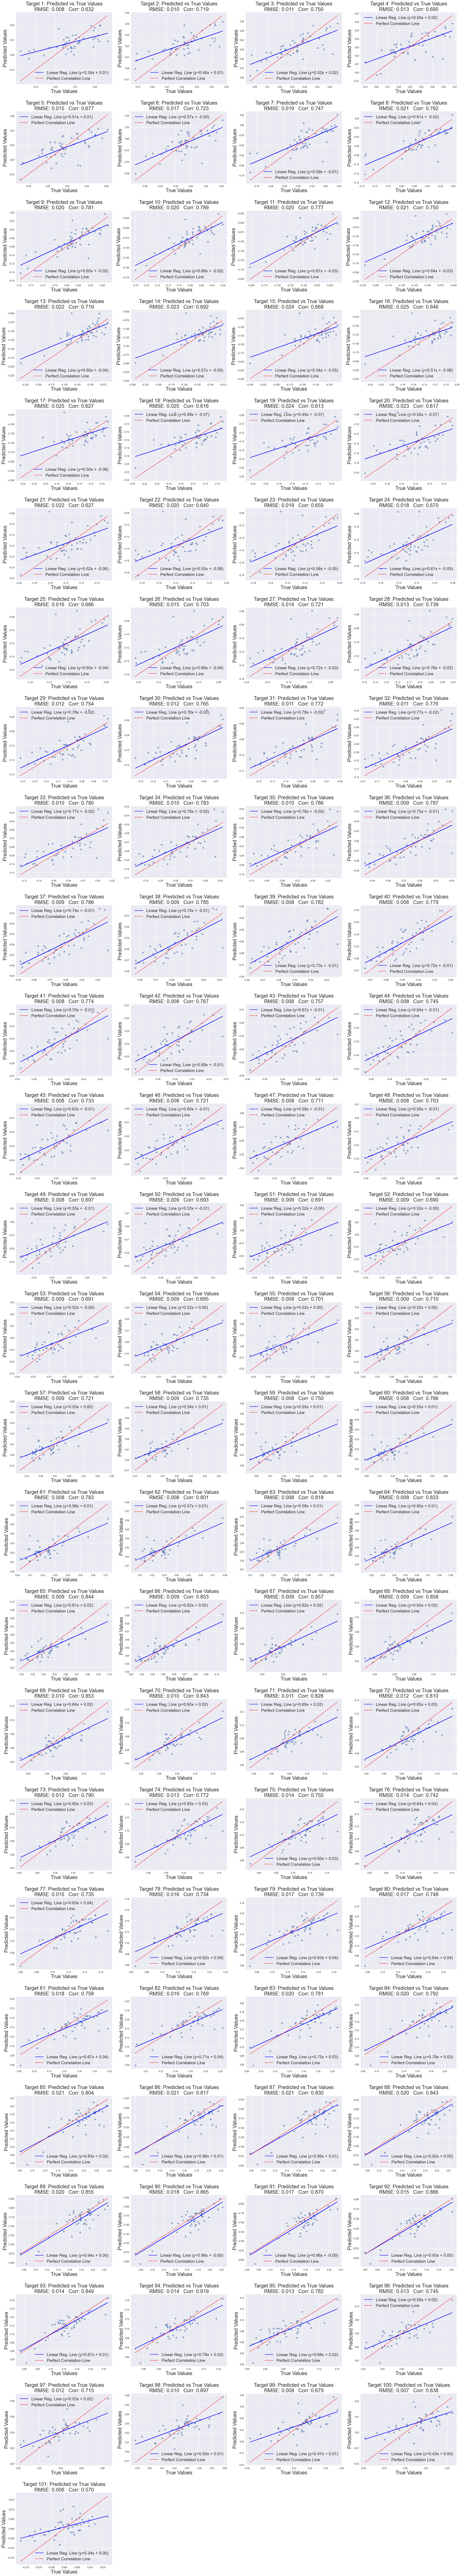

In [134]:
# Model 5 (PLS):
plot_predictions_vs_true(y_true=y_test_A2, 
                         y_pred=y_pred_test_A2, 
                         rmse_scores_test = rmse_scores_test_A2,
                         corr_target_test = corr_target_test_A2)

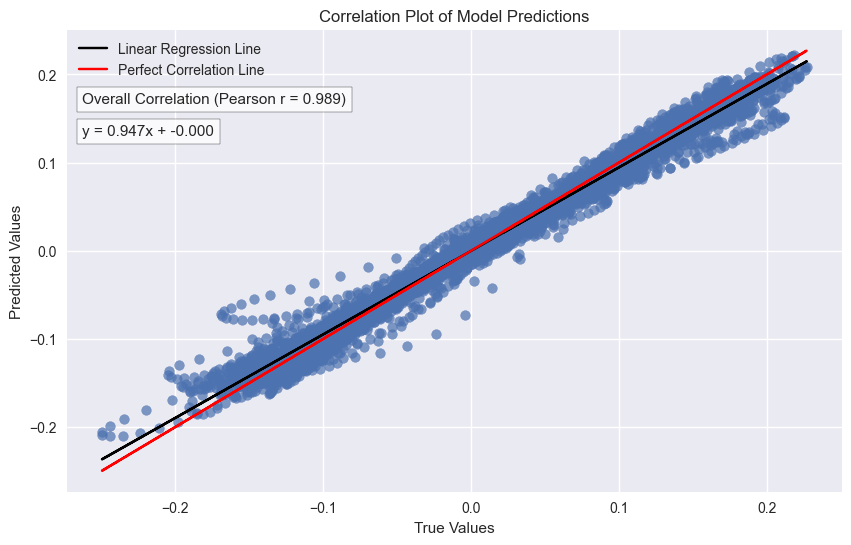

In [117]:
# Model 5 (PLS): global correlation plot of the model's predictions with all points and the perfect correlation line: 8 components
plot_correlation_model(y_true=y_test_A2, y_pred=y_pred_test_A2, overall_corr_coeff=overall_corr_test_A2)

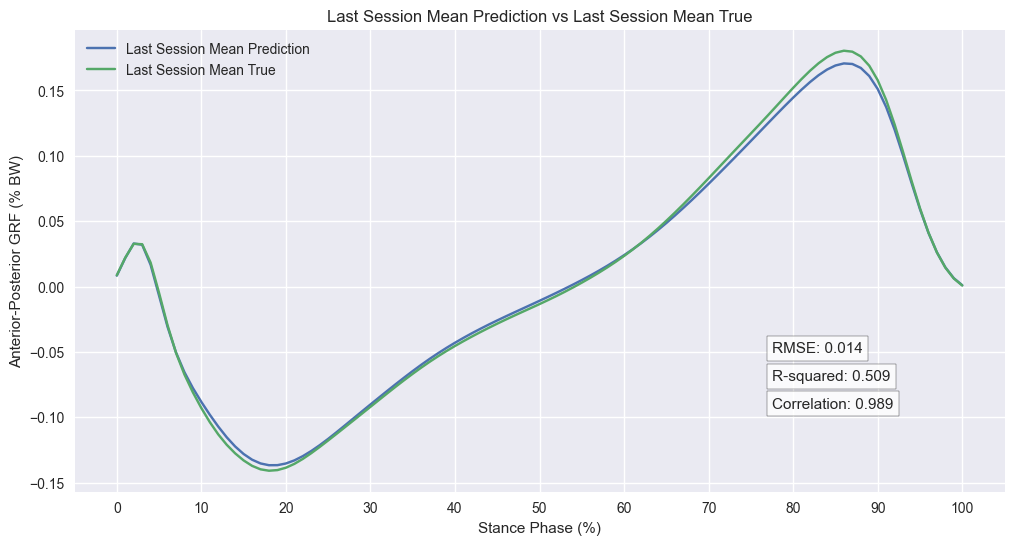

In [118]:
# Model 5 (PLS):
plot_last_session_mean_prediction_vs_mean_true(y_true = y_test_A2, 
                                               y_pred = y_pred_test_A2, 
                                               overall_rmse = overall_rmse_test_A2,
                                               overall_corr = overall_corr_test_A2,
                                               overall_r2 = overall_R2_test_A2,
                                               time_points = 101,
                                               x_ticks= 10)

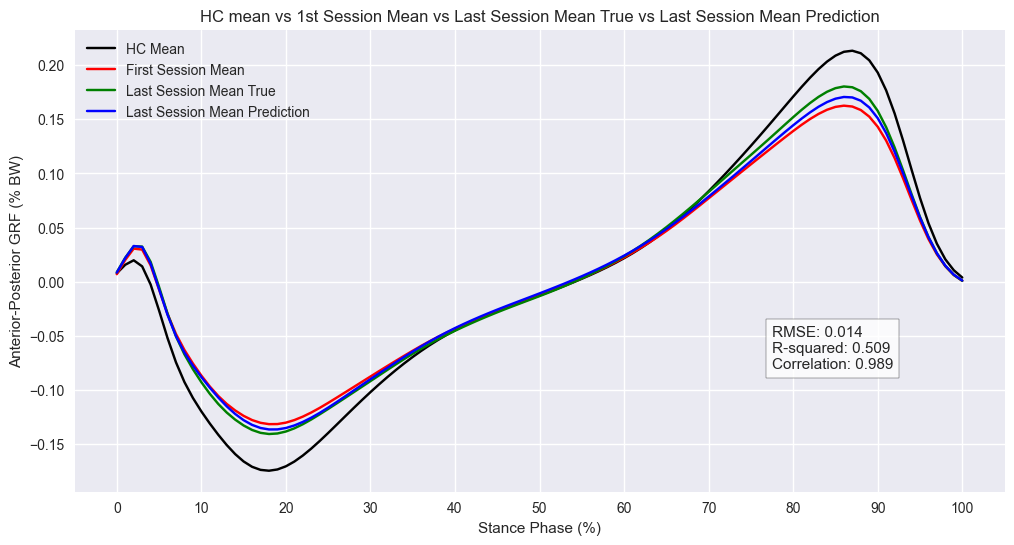

In [119]:
#### Model 5 (PLS):
plot_system_output(hc_means = calculate_mean_curve_HC(),
                    first_session = X_test_A2, 
                    y_true = y_test_A2, 
                    y_pred = y_pred_test_A2, 
                    overall_rmse = overall_rmse_test_A2,
                    overall_corr = overall_corr_test_A2,
                    overall_r2 = overall_R2_test_A2,
                    time_points = 101)

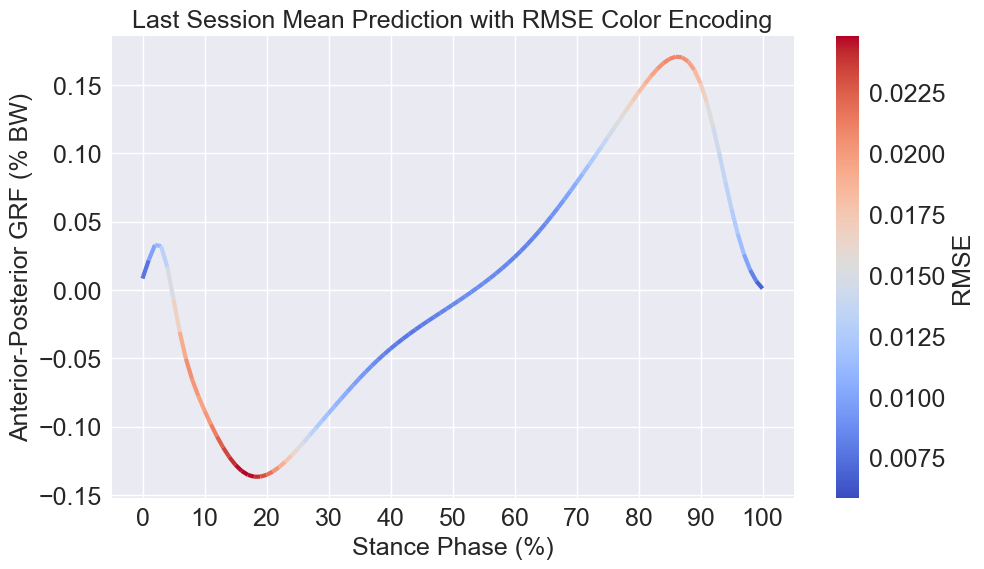

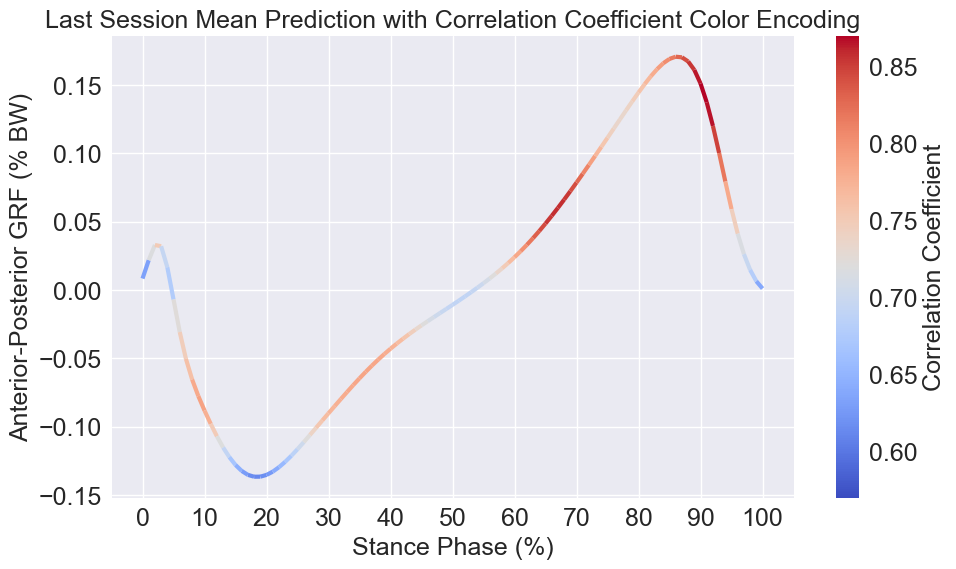

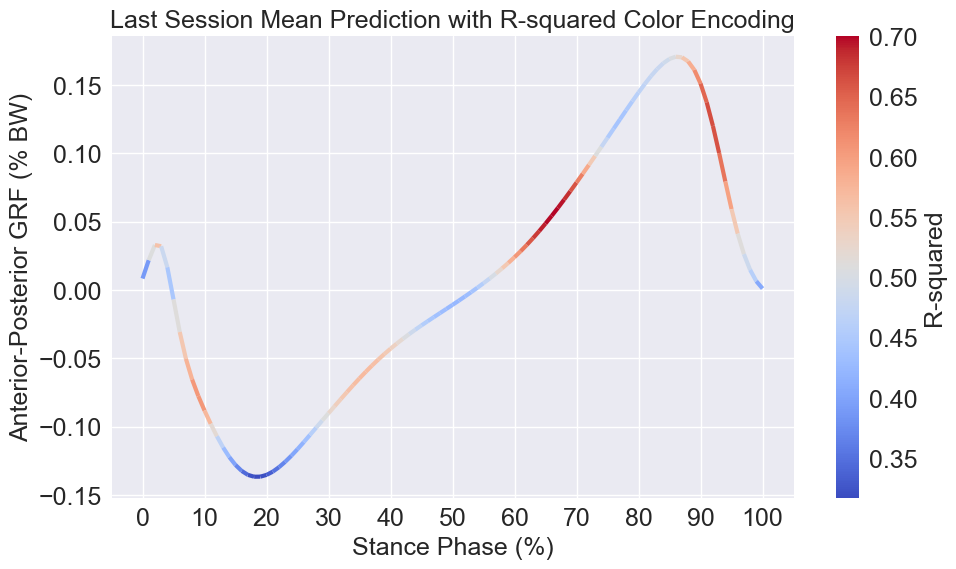

In [132]:
# Model 5: plot last session mean prediction with RMSE color encoding
plot_last_session_mean_prediction_with_rmse(y_true=y_test_A2, 
                                            y_pred=y_pred_test_A2, 
                                            rmse_scores_test=rmse_scores_test_A2,
                                            time_points=101)

# Model 5: plot last session mean prediction with correlation coefficient color encoding
plot_last_session_mean_prediction_with_corr(y_true=y_test_A2, 
                                            y_pred=y_pred_test_A2, 
                                            corr_target_test=corr_target_test_A2)
                                                  
# Model 5: plot last session mean prediction with R-squared color encoding
plot_last_session_mean_prediction_with_r2(y_true=y_test_A2, 
                                          y_pred=y_pred_test_A2, 
                                          r_squared=R2_target_test_A2)

##### Análisis de los residuos 

In [99]:
residuals = y_test_A2- y_pred_test_A2
len(residuals.flatten())

4848

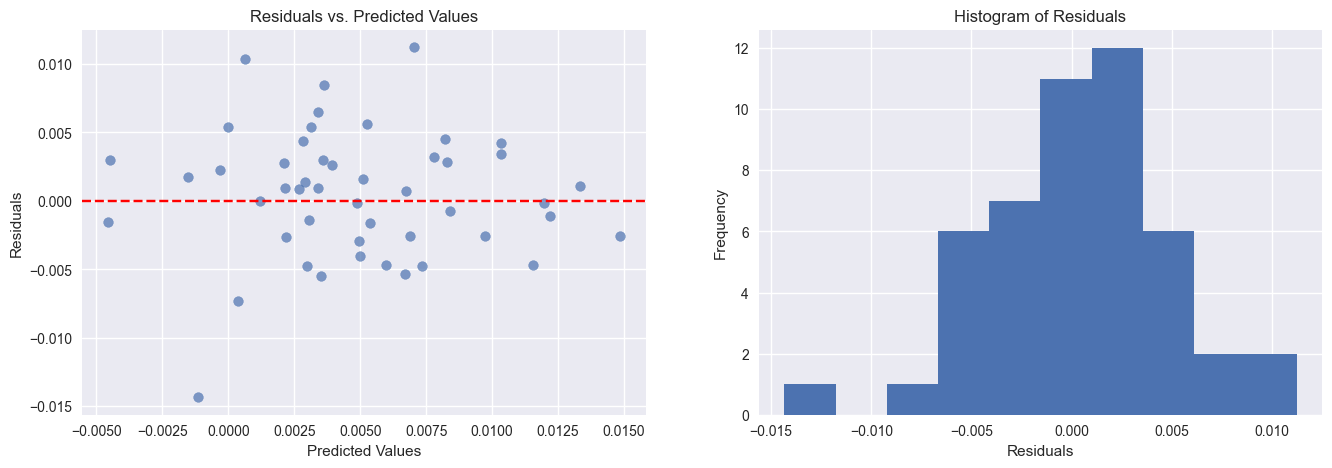

In [124]:
# Model 5 (PLS) Residual Analysis:
residual_analysis(y_test_A2, y_pred_test_A2, 10)

## Métricas de evaluación del modelo PLS

In [129]:
# 8 COMPONENTS
print('RMSE')
print(rmse_scores_test_A2)
print('\n')
print('R2')
print(R2_target_test_A2)
print('\n')
print('Correlation coefficient')
print(corr_target_test_A2)
print('\n')
print('Overall RMSE')
print(f"{overall_rmse_test_A2:.3f}")
print('\n')
print('Overall R2')
print(f"{overall_R2_test_A2:.3f}")


RMSE
[0.007665056038145547, 0.009913386987506436, 0.011083773767476813, 0.013196591665352213, 0.015037577714493653, 0.016678511062409796, 0.019174978866019855, 0.020585444237448337, 0.020185636823999067, 0.019667437368406548, 0.020099589106958044, 0.021226947196697193, 0.02242114567206286, 0.02331720382534681, 0.024033784234260273, 0.024621698449347282, 0.0248364755957007, 0.024623546322487505, 0.024016846385535577, 0.023036491969352927, 0.021767318618476788, 0.02035690830544245, 0.018929637211717965, 0.017564317642527187, 0.016301750036280795, 0.0151591147437342, 0.014117197468276822, 0.013185798501618598, 0.012404063416992038, 0.011788706759437885, 0.011299650113552532, 0.01087930418891245, 0.010478166540891946, 0.010078478903655234, 0.009692103937590842, 0.009335893993472599, 0.00901066984690745, 0.008703676656241721, 0.008409798635087513, 0.008148413537585263, 0.007951869511876047, 0.007837358166310551, 0.007804295328521694, 0.007837971843809305, 0.007917792922372616, 0.00802770195